# Step1 Collecting Data

## Obtain the coins index from the `Tokens` endpoint

In [1]:
import requests
from pandas import json_normalize
from urllib.parse import urlencode

from typing import Dict, List, Union, Optional, Any

import warnings
warnings.filterwarnings("ignore")

In [2]:
API_key = '<Your API Key>'

def tm_API(endpoint: str, payload: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
	"""Obtain data from the Token Metrics Data API

	Args:
		endpoint (str): The endpoint of the API
		payload (Optional[Dict[str, Any]], optional): The parameters to send to the API. Defaults to None.

	Returns:
		Dict[str, Any]: The response from the API
	"""

	if payload:
		url = 'https://alpha.data-api.tokenmetrics.com/v1/' + endpoint + '?' + urlencode(payload)
	else:
		url = 'https://alpha.data-api.tokenmetrics.com/v1/' + endpoint 
	headers = {'Accept': 'application/json', 'Content-Type': 'application/json', 'api_key': API_key}
	response = requests.get(url, headers=headers)
	return response.json()

In [3]:
endpoint = 'tokens'
params = {}
response = tm_API(endpoint,params)
coins = json_normalize(response['data'])
coins = coins.sort_values(by = 'TOKEN_ID').reset_index(drop = True)

In [23]:
coins[coins.NAME.isin(['Bitcoin','Ethereum','Litecoin'])].reset_index(drop = True)

,TOKEN_ID,SYMBOL,NAME
0,3306,ETH,Ethereum
1,3375,BTC,Bitcoin
2,3377,LTC,Litecoin


## Obtain the market data for the `BTC`

In [24]:
import pandas as pd
import datetime as dt
import requests

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

In [28]:
# Obtain data from the Binance US API
params = {'symbol': 'BTCUSDT', 
       'interval': '1d', 
       'startTime': int(dt.datetime(2020,5,2).timestamp())*1000,
       'endTime': int(dt.datetime(2023,1,28).timestamp())*1000,
       'limit': 1000}
r = requests.get('https://api.binance.us/api/v3/klines', params = params).json()

# Convert to pandas dataframe
col = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades',
       'Taker buy volume','Taker buy quote asset volume','Ignore']
btcusdt = pd.DataFrame(r, columns = col)

btcusdt['Open time'] = btcusdt['Open time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000)).dt.strftime('%Y-%m-%d')
btcusdt['Close time'] = btcusdt['Close time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000)).dt.strftime('%Y-%m-%d')

# Clean up the data
btcusdt.rename(columns = {'Close time': 'Date'}, inplace = True)
btcusdt[['Open', 'High', 'Low', 'Close', 'Volume']] = btcusdt[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
btcusdt = btcusdt[['Date','Open', 'High', 'Low', 'Close', 'Volume']]
btcusdt


,Date,Open,High,Low,Close,Volume
0,2020-05-03,8973.85,9196.27,8718.08,8887.35,210.049083
1,2020-05-04,8896.62,8954.26,8528.63,8868.92,198.322480
2,2020-05-05,8878.25,9105.20,8772.22,9027.64,133.862430
3,2020-05-06,9022.44,9396.16,8918.99,9145.93,242.577093
4,2020-05-07,9132.52,10063.93,9010.00,9991.11,340.351689
...,...,...,...,...,...,...
995,2023-01-23,22710.87,23173.98,22514.16,22915.06,2640.997861
996,2023-01-24,22913.74,23157.50,22473.84,22631.85,2143.908361
997,2023-01-25,22639.70,23809.38,22340.00,23055.67,2197.009498
998,2023-01-26,23071.15,23274.74,22858.60,23005.88,1193.341499


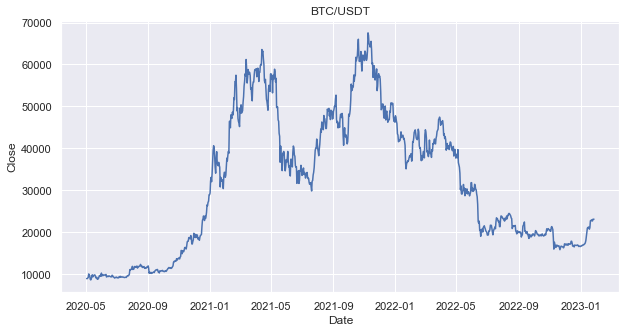

In [30]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(x=pd.to_datetime(btcusdt['Date']), y=btcusdt['Close'])
plt.title('BTC/USDT')
plt.savefig('../Plots/btcust.png')

## Obtain the `trader-grades`

In [16]:
endpoint = 'trader-grades'
params = {
	'tokens': '3375',
	'startDate': '2020-05-03T00:00:00.000Z',
	'endDate': '2023-01-27T00:00:00.000Z',
	'limit': 1000

}
r = tm_API(endpoint,params)
trader_grades = json_normalize(r['data'])

In [17]:
# select the columns we want
btc_tg = trader_grades[['DATE','TA_GRADE','QUANT_GRADE','TM_TRADER_GRADE',]]

# merge the data
data = pd.merge(btc_tg, btcusdt, left_on='DATE', right_on='Date', how='left').drop('Date', axis=1)

# do some transformations
data['DATE'] = pd.to_datetime(data['DATE'])

In [18]:
data['DayReturnPCT'] = (data.Close/data.Close.shift(-1) - 1)*100
data['ta_gradePCT'] = (data['TA_GRADE']/data['TA_GRADE'].shift(-1) - 1)*100
data['quant_gradePCT'] = (data['QUANT_GRADE']/data['QUANT_GRADE'].shift(-1) - 1)*100
data['tm_trader_gradePCT'] = (data['TM_TRADER_GRADE']/data['TM_TRADER_GRADE'].shift(-1) - 1)*100
data['DailyReturnPCT'] = (data.Close/data.Open - 1)*100

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 0 to 747
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                748 non-null    datetime64[ns]
 1   TA_GRADE            747 non-null    float64       
 2   QUANT_GRADE         747 non-null    float64       
 3   TM_TRADER_GRADE     746 non-null    float64       
 4   Open                748 non-null    float64       
 5   High                748 non-null    float64       
 6   Low                 748 non-null    float64       
 7   Close               748 non-null    float64       
 8   Volume              748 non-null    float64       
 9   DayReturnPCT        747 non-null    float64       
 10  ta_gradePCT         745 non-null    float64       
 11  quant_gradePCT      745 non-null    float64       
 12  tm_trader_gradePCT  743 non-null    float64       
 13  DailyReturnPCT      748 non-null    float64       

In [21]:
data.to_csv('../Data/btc_tg.csv', index=False)